# 1. Introdução


Inspired by the way the human brain works as described by neuroscience in the 1960s, Artificial Intelligence scientists developed Artificial Neural Networks. These networks are based on artificial neurons, which can be described by input parameters, an activation function and output weights. Since the creation of such technology, researchers have become increasingly interested in these networks, particularly for their ability to perform distributed computing and to be able to learn rather complex functions. Currently, Artificial Neural Networks are one of the most popular and effective ways of implementing machine learning.

Convolutional Neural Networks, in their turn, are a special type of Neural Networks specialized in processing data that have a matrix topology, for example, time series, audio data and, especially, images. The name of this type of network already indicates that it implements a special type of mathematical operation: convolution. Among the reasons for using these networks, instead of the conventional Neural Networks, we can highlight: the sparse interactions and the sharing of parameters. These two characteristics allow Convolutional Neural Networks to use less memory for training their learning function, in addition to using less time complexity.

Within this context, this work proposes to use the Convolutional Neural Networks to perform the image prediction of the [CIFAR-10](https://www.kaggle.com/c/cifar-10) data set. It is a dataset with 50,000 training images, divided into 10 classes. Using techniques such as Data Augmentation, MaxPooling, Dropouts, Batch Normalization and L2 Regularization, it was possible to avoid common problems such as Overfitting and achieve a prediction accuracy of up to 88.85%.




# 2. Importing Data from CIFAR-10



First, we import the necessary libraries. The CIFAR-10 dataset can be found on the keras.datasets.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)v
import matplotlib.pyplot as plt # data visualization
import seaborn as sns

from keras.datasets import cifar10 # CIFAR-10 dataset
from keras.utils import np_utils, plot_model # np_utils is used to do one-hot encoding
from keras.optimizers import Adam # adam optmizer
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization # layers used in the neural network
from keras.regularizers import l2 # l2 regularizer
from keras.models import Sequential, load_model # the model used has the Sequential structure
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report


from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator


Next, we get the train and test sets using the load_data function from the cifar10 and visualize the size of the datasets, as well as some of its images.

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
labels = pd.read_csv('/kaggle/input/cifar-10/trainLabels.csv')

In [ ]:
# Datasets shapes
print('Train dataset shape: {}'.format(X_train.shape))
print('Test dataset shape: {}'.format(X_test.shape))

In [ ]:
print('Amount of images in each class of the training dataset:')
print(labels.label.value_counts())

By looking at the amount of images in each class of the training dataset, we can determine a baseline accuracy, given by a model that always guesses a certain class. The value of this accuracy is given by 5000 / (10 * 5000) = 10%.

Some of the images of each class is shown below.

In [ ]:
# Getting a dictionary with 3 images indexes for each label
labels_dict = {}
for label in labels.label.unique():
    labels_dict[label] = list(labels[labels['label'] == label].index[0:3])
    
# Showing 3 images of every class
for key in labels_dict:
    for i in range(3):
        plt.subplot(330+ 1 + i)
        plt.imshow(X_train[labels_dict[key][i]])
    print('Class {}'.format(key))
    plt.show()


# 3. Tools Used

**3.1 Data Augmentation**

Data Augmentation is a commom technique used in Machine Learning projects to increase the amount of data applied in the training using the available data. In generating ew copies of training data, it's possibler to increase the generality of the model, thus reducing overfitting. When used in images, the most commom methods of data augmentation are rotation, zooming, height and width shifting, vertical and horizontal flipping, stretching, among others.

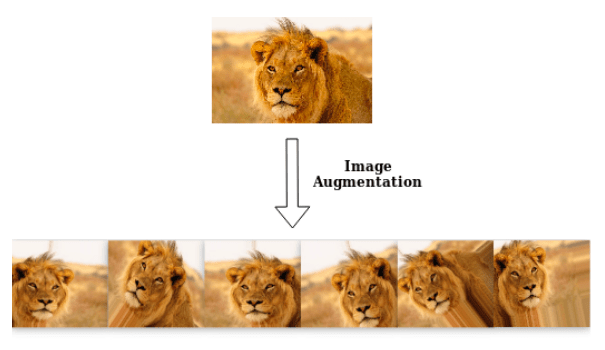

We can use the class ImageDataGenerator from Keras to easily generate new training images from the CIFAR-10 dataset.

In [ ]:
# Initializing a ImageDataGenerator Objetc
image_data_generator = ImageDataGenerator(
                rotation_range = 15, # degree angle for random rotations
                horizontal_flip = True, # randomly flips the image horizontally
                width_shift_range = 0.1, # fraction of total width shift
                height_shift_range = 0.1 # fraction of total height shift
                )

# Fitting the Image Data Generator for the training images

image_data_generator.fit(X_train)

Next, we can see a few of the images that were generated.

In [ ]:
training_generator = image_data_generator.flow(X_train, y_train, batch_size = 6)

In [ ]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in training_generator:
        plt.imshow(x[i].astype(np.uint8))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

We also would like to apply the z-score normalization to the training and testing datasets. The reason for this is because in the process of training the network, a lot of parameters (weights) are shared. The weights learned in the process are multiplied by the input data in order to cause activations. Ideally, each input in the neural network must have similar range of pixels. If the range of each input is very different, it becomes hard to train the model. Originally, the range of values that the image pixels can assume is between 0 and 225, but by applying the z-score normalization this range drops to between -XXX and YYY. 

The z-score normalization is done accordingly to the following equation:

z = (x - μ)/σ, 

where:
* μ: Mean
* σ: Standart Deviation

In [ ]:
# Transform the data type to float 32 to performe the divison operation 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Functions from numpy to calculate mean and std
mean = np.mean(X_train)
std = np.std(X_train)

# Applying the z-score

X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)

**3.2 Pooling**

The pooling function replaces the output of the net at a certain location with a summary statistic of the nearby outputs. For example, max pooling operation reports the maximum output within a rectangular neighborhood.

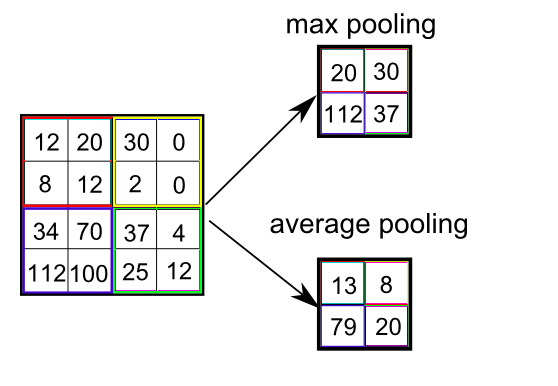

Max pooling is a very commom operation in Machine Learning projects because it helps to make the representation approximately invariant to small changes of the input. This means that if we change the input by a small amount, the values of most of the pooled outputs do not change. Invariance to local changes can be a very useful property if we are more interested about wheter some feature is present then about where it is.

By applying pooling between separately parametrized convolutions, the model can learn to witch transformations it can become invariant to. For example, the model can become invariant to rotations apllied to the images. Max pooling helps prevent overfitting by providing an abstracted form of representation, as well as reducing the computational cost of the model.

****3.3 Dropouts****

Dropout is a very simple, popular and useful technique to combat the overfitting of models. Dropout works by ignoring randomly chosen nodes or convolutions for briefs parts of training. Specifically it makes each convolution or node find information that is useful for prediction in its own right, rather than allowing one node to dominate the prediction. This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

Dropout simulates a sparse activation from a given layer, which interestingly, in turn, encourages the network to actually learn a sparse representation as a side-effect.

The Dropout Rate is a hyperparameter that must be adjusted. A good rule of thumb is to divide the number of nodes in the layer before dropout by the proposed dropout rate and use that as the number of nodes in the new network. For example, a network with 64 nodes and a dropout rate of 0.5 will require 128 nodes.


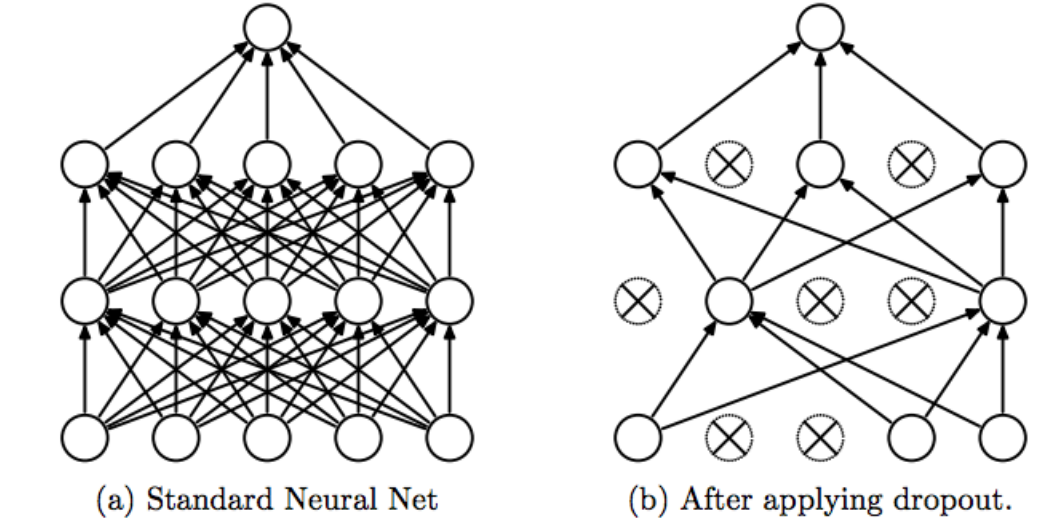

**3.4 Regularization**

Regularization is a technique used to penalize complex models. Instead of simply aiming to minimize the loss function, we try to minimize the loss + complexity, witch is called structural risk minimization. The two most commom regularization functions are L1 and L2 regularization.

The L1 regularization adds the absolute value of magnitude of each coefficient in the neural network as penalty term to the loss function. The L2 function, instead, adds the squared magnitude of the coefficients as the penalty term.

The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether




**3.5 Batch Normalization**

Just as the data is normalized for the input layer, so that the range of values of the features is within a normal pattern, it is also possible to perform such normalization for the deeper layers. This process is called batch normalization. Batch normalization reduces the amount by what the hidden unit values shift around (covariance shift) and allows each layer of a network to learn by itself a little bit more independently of other layers.

To increase the stability of a neural network, batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. However, after this shift/scale of activation outputs by some randomly initialized parameters, the weights in the next layer are no longer optimal. SGD ( Stochastic gradient descent) undoes this normalization if it’s a way for it to minimize the loss function.
Consequently, batch normalization adds two trainable parameters to each layer, so the normalized output is multiplied by a “standard deviation” parameter (gamma) and add a “mean” parameter (beta). In other words, batch normalization lets SGD do the denormalization by changing only these two weights for each activation, instead of losing the stability of the network by changing all the weights.

Reference: https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

# 4. Creating the Model

Before defining the model itself, we need to define the number of the classes, define the input shape of the images and apply the one-hot encoding to the labels.

In [ ]:
# every image has the same input_shape
input_shape = (32,32,3)

# number of classes in the CIFAR-10
n_classes = 10

# applying the one-hot encoding
y_train = np_utils.to_categorical(y_train,n_classes)
y_test = np_utils.to_categorical(y_test,n_classes)

The neural network has the Sequential type. This means that every layer is connected to the next in a unilateral sequence. The model architecture was developed through an iterative process. Like the hyperparameters, the chosen architecture strongly impacts the performance of the model. The neural network has 6 convolutional layers, a dense layer and a final classification layer. Max pooling, dropout and batch normalization operations are performed between some of these layers. The model architecture is illustrated below.

* First, we have a convolutional layer with 32 neurons and the activation function ReLu (Rectified Linear Unit). This is a typical number of neurons, just as the activation function is also widely used in neural networks. The size of the kernel filter is 3x3 and was chosen according to the size of the input image. Then, the output of this layer is normalized by a Batch Normalization layer

* The next layer repeats the pattern of the first, with the same number of neurons, the same size of the kernel filter and a layer of batch normalization in the output. Then, a Max Pooling operation is applied, which reduces the data dimensions to 16x16. A 10% dropout is then applied to avoid overfitting. This value was determined by an iterative process.

* The next layers repeat the structure of the first two, changing only the number of neurons used. The number of neurons doubles every two layers. Meanwhile, the size of the data halves with each layer of Max Pooling

* Finally, a Flatten layer is added, followed by a dense layer of 512 neurons. Batch normalization is performed again and a 50% dropout is added. The classification layer has the softmax activation function



In [ ]:
def model():
    # L2 λ = 0.0005
    regularizer = l2(0.0005)
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation = 'relu', kernel_regularizer = regularizer, input_shape = input_shape, padding = 'same'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_regularizer = regularizer, padding = 'same'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(64, (3,3), activation = 'relu', kernel_regularizer = regularizer, padding = 'same'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_regularizer = regularizer, padding = 'same'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, (3,3), activation = 'relu', kernel_regularizer = regularizer, padding = 'same'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(128,(3,3), activation = 'relu', kernel_regularizer = regularizer, padding = 'same'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.1))
    

    
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu', kernel_regularizer = regularizer))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation = 'softmax'))
    
    return model
    
model = model()
# Using keras Adam optimizer
AdamOpt = Adam(lr = 0.0003)

model.compile(optimizer = AdamOpt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()
    
    

A comparison model was also developed. It has the same architecture as the first, however, no batch normalization or dropout layers are added. The purpose of this is to verify how important these tools are to avoid overfitting, in addition to improving the overall performance of the project.

In [ ]:
def comparison_model():
    # No Regularizer
    regularizer = None
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation = 'relu', kernel_regularizer = regularizer, input_shape = input_shape, padding = 'same'))
    # No batch normalization
    #model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(32,(3,3), activation = 'relu', kernel_regularizer = regularizer, padding = 'same'))
    #model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    # No dropout
    #model.add(Dropout(0.1))
    
    model.add(Conv2D(64, (3,3), activation = 'relu', kernel_regularizer = regularizer, padding = 'same'))
    #model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(64,(3,3), activation = 'relu', kernel_regularizer = regularizer, padding = 'same'))
    #model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #model.add(Dropout(0.1))
    
    model.add(Conv2D(128, (3,3), activation = 'relu', kernel_regularizer = regularizer, padding = 'same'))
    #model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(128,(3,3), activation = 'relu', kernel_regularizer = regularizer, padding = 'same'))
    #model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #model.add(Dropout(0.1))
    

    
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu', kernel_regularizer = regularizer))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation = 'softmax'))
    
    return model
    
comparison_model = comparison_model()
# Using keras Adam optimizer
AdamOpt = Adam(lr = 0.001)

comparison_model.compile(optimizer = AdamOpt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    

# 5. Training the Neural Network

For training the model, we used two callback functions. The first to perform the early stop (avoiding overfitting) if the loss validation function does not improve after 15 epochs. We also use the keras ModelCheckpoint to save the neural network weights for the best model found in the training process. The number of epochs used was 200. The batch size is one of the hyperparameters to be adjusted. A size of 128 seems adequate for the size of the data set used.

For training the comparison model, the augmented data set will not be used, according to the procedure described in section 3.1.

In [ ]:
# CallBack functions
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Training history
history = model.fit(image_data_generator.flow(X_train,y_train, batch_size = 200), steps_per_epoch = len(X_train)/200, epochs = 200, validation_data = (X_test,y_test), callbacks=[es, mc])



In [ ]:
# load the saved model
saved_model = load_model('best_model.h5')

In [ ]:
# CallBack functions
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=117)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Training history
# 117 = number of epochs of the first model
comparison_history = comparison_model.fit(X_train, y_train, batch_size = 200, verbose = 1, epochs = 117, validation_data = (X_test,y_test), callbacks=[es, mc])


# **6. Results**

**6.1 Accuracy over epochs**

From the history obtained in the training process, we can plot graphs of the loss function and the accuracy of the training set and the test set over the epochs. We can see that the comparison model has a performance far inferior to the proposed model. In addition, we can see a big reduction in overfitting when implementing the techniques described in section 3.


In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,7)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history

plotmodelhistory(history)

In [ ]:
plotmodelhistory(comparison_history)

The best accuracy for the models developed for the training and validation sets is shown below:

In [ ]:
max_val_acc = max(history.history['val_accuracy'])
max_train_acc = max(history.history['accuracy'])

min_val_loss = min(history.history['val_loss'])
min_train_loss = min(history.history['loss'])

print('Validation set: \nAccuracy: {}\nLoss: {}'.format(max_val_acc,min_val_loss))
print()
print('Train set: \nAccuracy: {}\nLoss: {}'.format(max_train_acc,min_train_loss))


**6.2 Confusion Matrix**

The confusion matrix allows us to observe the predictions that were made correctly, as well as false positives and false negatives. The confusion matrix for the developed model is shown below.

In [ ]:
# Get the predictions probabilities
predictions = model.predict(X_test)

# Get the true predictions
y_predictions = np.argmax(predictions, axis=1)

# Remove the one-hot encoding from the test label
y_true = np.argmax(y_test, axis=1)


# Getting the confusion matrix
cm = confusion_matrix(y_true, y_predictions)

# Transform to DataFrame and change the names of indexes and columns
cm = pd.DataFrame(cm)

cm.rename(columns={0:'Airplane',
                  1: 'Automobile',
                  2: 'Bird',
                  3: 'Cat',
                  4: 'Deer',
                  5: 'Dog',
                  6: 'Frog',
                  7: 'Horse',
                  8: 'Ship',
                  9: 'Truck'
                        }, 
                 inplace=True)
cm.rename(index={0:'Airplane',
                  1: 'Automobile',
                  2: 'Bird',
                  3: 'Cat',
                  4: 'Deer',
                  5: 'Dog',
                  6: 'Frog',
                  7: 'Horse',
                  8: 'Ship',
                  9: 'Truck'
                        }, 
                 inplace=True)

In [ ]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title("Confusion matrix")

# Heatmap showing 
sns.heatmap(data=cm, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")

# Add label for horizontal axis
plt.xlabel("Predicted Label")
plt.xlabel("True Label Label")

plt.show()

**6.4 Classification Report**

The classification report allows us to observe the other evaluation metrics for each of the classes: precision, recal F1-score and support.

In [ ]:
print(classification_report(y_true, y_predictions))

# **7. Conclusions**

* After performing the modeling with the Convolutional Neural Networks and the prediction of the set of tests, an accuracy of 88.85% was obtained. Some reflections about the work, as well as possible improvements are indicated below.

* The optimization of hyper parameters is a big step towards the general optimization of the model. Algorithms that perform such optimization could be applied to improve the overall accuracy of the model, such as a state space search.


* We can see that by applying the techniques proposed in section 3, the overfitting has drastically reduced when compared to the comparison model. Although the comparison model has obtained a higher accuracy in the training set, such accuracy is not a valid metric for the evaluation of the model.

* Some classes of similar animals, such as cats and dogs or horses and deers have obtained the highest amount of wrong predictions. This could be fixed with special data augmentation preprocessing for each of these classes.
